# **Time Series Forecasting**

In [19]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import yfinance as yf

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

# Redes LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings('ignore')

In [20]:
data_googl=yf.download('GOOGL', start="2011-01-01", end="2024-10-30")
data_googl=data_googl[['Adj Close']]
#data_googl=data_googl.reset_index()
data_googl=data_googl.asfreq('M')
data_googl['Adj Close']=data_googl['Adj Close'].fillna(method='bfill')
data_googl['Adj Close']=data_googl['Adj Close'].fillna(method='ffill')
data_googl

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2011-01-31,14.986914
2011-02-28,15.312434
2011-03-31,14.647415
2011-04-30,13.206038
2011-05-31,13.206038
...,...
2024-05-31,172.073914
2024-06-30,171.312668
2024-07-31,171.312668


In [21]:
print(f'Total de vacios {data_googl.isnull().sum().sum()}')

Total de vacios 0


# **EDA**

In [22]:
data_googl.tail()

,Adj Close
Date,
2024-05-31,172.073914
2024-06-30,171.312668
2024-07-31,171.312668
2024-08-31,165.850006
2024-09-30,165.850006


Fechas train : 2011-01-31 00:00:00 --- 2023-01-31 00:00:00  (n=145)
Fechas test  : 2023-01-31 00:00:00 --- 2024-09-30 00:00:00  (n=21)


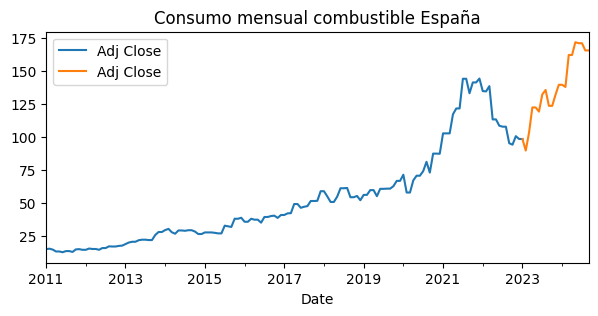

In [23]:
fin_train = '2023-01-31'
print(
    f"Fechas train : {data_googl.index.min()} --- {data_googl.loc[:fin_train].index.max()}  "
    f"(n={len(data_googl.loc[:fin_train])})"
)
print(
    f"Fechas test  : {data_googl.loc[fin_train:].index.min()} --- {data_googl.loc[:].index.max()}  "
    f"(n={len(data_googl.loc[fin_train:])})"
)
datos_train = data_googl.loc[:fin_train]
datos_test  = data_googl.loc[fin_train:]

# Gráfico
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.set_title('Consumo mensual combustible España')
ax.legend()
plt.show()

In [24]:
data_googl['Adj Close_log']=data_googl['Adj Close'].apply(np.log)
data_googl['Adj Close_log_diff']=data_googl['Adj Close_log'].diff()
data_googl.dropna(inplace=True,axis='rows')
data_googl.head()

,Adj Close,Adj Close_log,Adj Close_log_diff
Date,,,
2011-02-28,15.312434,2.728665,0.021488
2011-03-31,14.647415,2.684264,-0.044401
2011-04-30,13.206038,2.580674,-0.103590
2011-05-31,13.206038,2.580674,0.000000
2011-06-30,12.640870,2.536935,-0.043739


In [25]:
data_googl.columns

Index(['Adj Close', 'Adj Close_log', 'Adj Close_log_diff'], dtype='object')

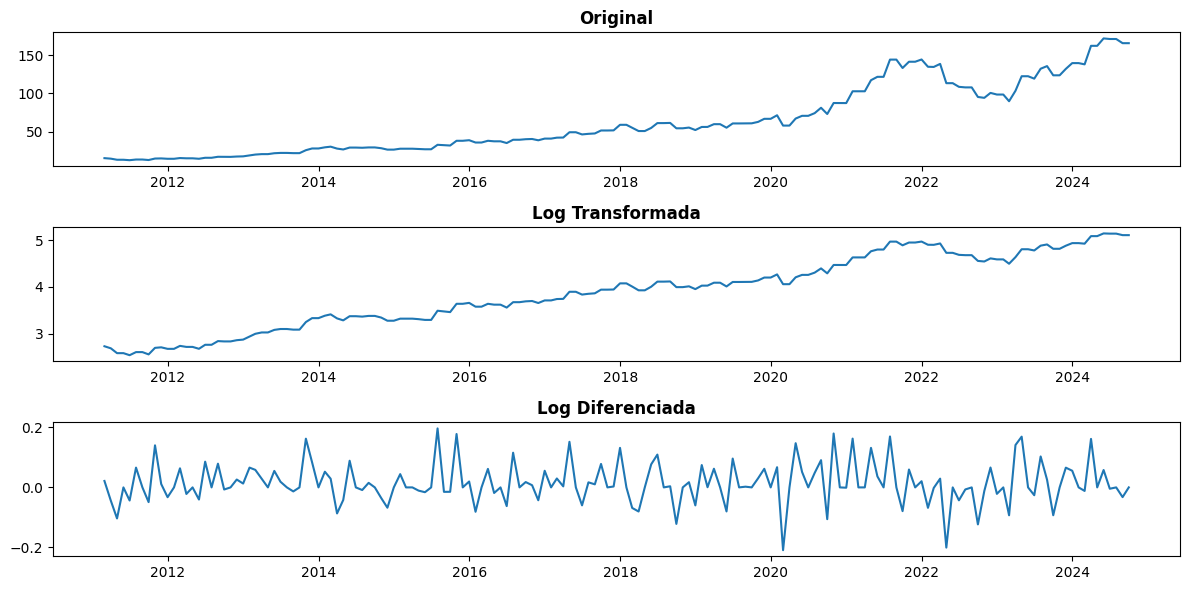

In [26]:
# Visualizar los datos originales y transformados
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(data_googl.index, data_googl['Adj Close'], label='Original')
plt.title('Original',fontsize=12,weight='bold')

plt.subplot(3, 1, 2)
plt.plot(data_googl.index, data_googl['Adj Close_log'], label='Log Transformada')
plt.title('Log Transformada',fontsize=12,weight='bold')

plt.subplot(3, 1, 3)
plt.plot(data_googl.index, data_googl['Adj Close_log_diff'], label='Log Diferenciada')
plt.title('Log Diferenciada',fontsize=12,weight='bold')

plt.tight_layout()
plt.show()

In [27]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [28]:
Prueba_Dickey_Fuller(data_googl['Adj Close'],'Adj Close')

Resultados de la prueba de Dickey-Fuller para columna: Adj Close
Test Statistic                          0.011210
p-value                                 0.959449
No Lags Used                            6.000000
Número de observaciones utilizadas    157.000000
Critical Value (1%)                    -3.472703
Critical Value (5%)                    -2.880132
Critical Value (10%)                   -2.576683
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


In [29]:
Prueba_Dickey_Fuller(data_googl['Adj Close_log_diff'],'Adj Close_log_diff')

Resultados de la prueba de Dickey-Fuller para columna: Adj Close_log_diff
Test Statistic                       -1.105929e+01
p-value                               4.855054e-20
No Lags Used                          1.000000e+00
Número de observaciones utilizadas    1.620000e+02
Critical Value (1%)                  -3.471374e+00
Critical Value (5%)                  -2.879552e+00
Critical Value (10%)                 -2.576373e+00
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


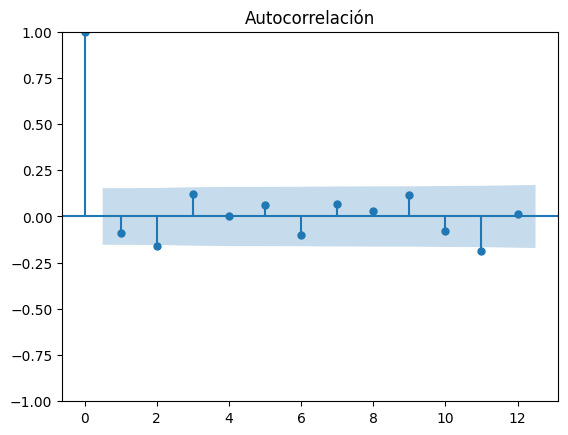

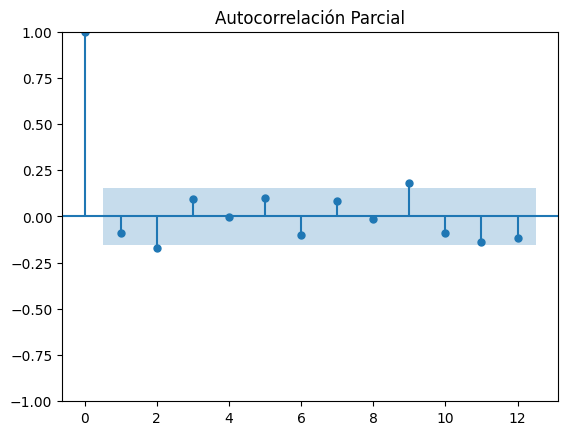

In [30]:
plot_acf(data_googl['Adj Close_log_diff'],lags=12,title='Autocorrelación')
plot_pacf(data_googl['Adj Close_log_diff'],lags=12,title='Autocorrelación Parcial')
plt.show()

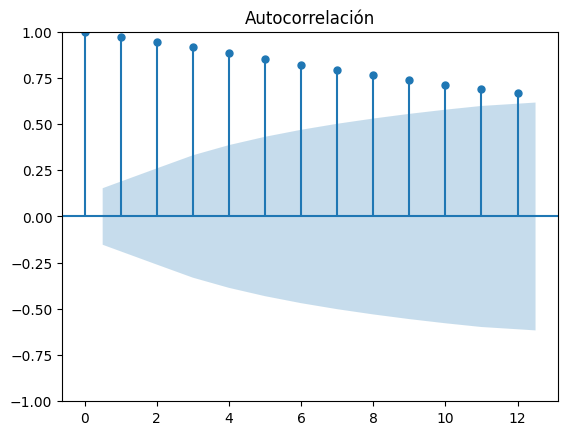

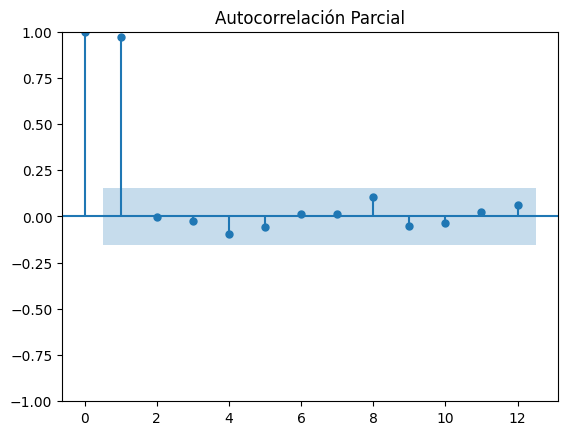

In [31]:
plot_acf(data_googl['Adj Close'],lags=12,title='Autocorrelación')
plot_pacf(data_googl['Adj Close'],lags=12,title='Autocorrelación Parcial')
plt.show()

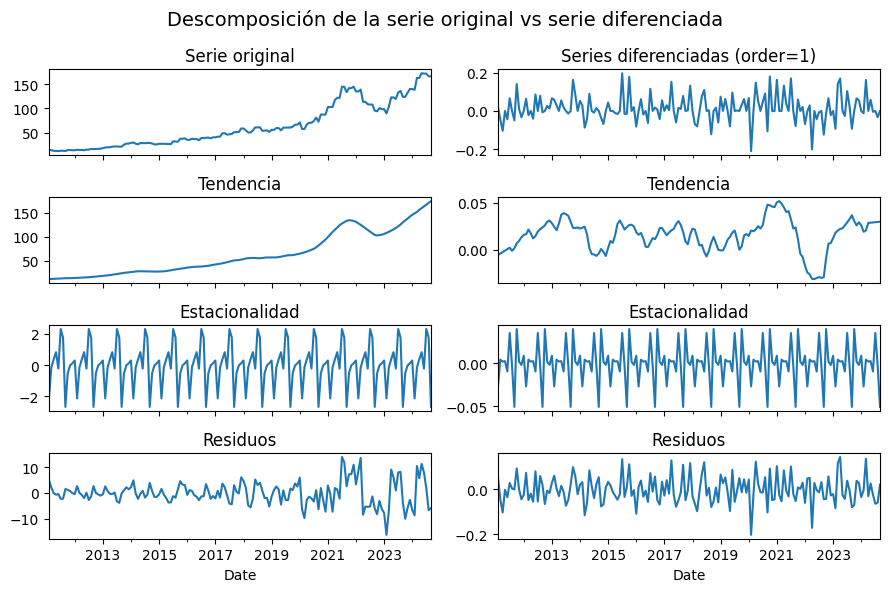

In [32]:
res_decompose = seasonal_decompose(data_googl['Adj Close'], model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(data_googl['Adj Close_log_diff'], model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout();

## **Modelo de Sarimax**

In [33]:
modelo=SARIMAX(endog=datos_train,order=(2,1,2),seasonal_order=(2,2,2,12))
modelo_res = modelo.fit(disp=0)
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'

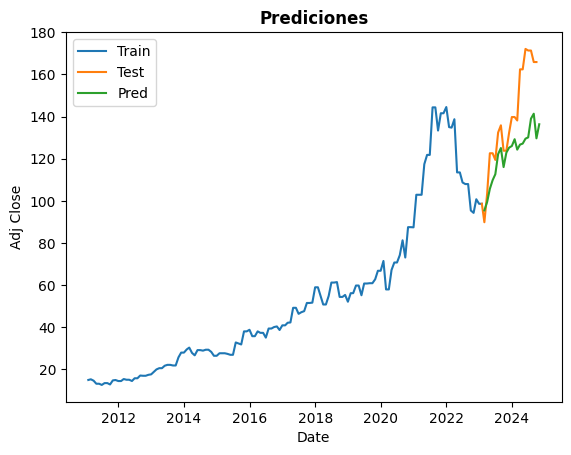

In [34]:
sns.lineplot(data=datos_train,x=datos_train.index,y='Adj Close',label='Train')
sns.lineplot(data=datos_test,x=datos_test.index,y='Adj Close',label='Test')
sns.lineplot(predicciones_statsmodels,label='Pred')
plt.title('Prediciones',fontsize=12,weight='bold')
plt.show()

## **Redes LSTM**

In [77]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [78]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled=data_googl[['Adj Close']]
data_scaled = scaler.fit_transform(data_scaled.values)

In [79]:
# Crear la serie de tiempo con secuencias (ventanas de tiempo)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


n_steps = 12  # Usar 12 meses anteriores para predecir el siguiente mes
X, y = create_sequences(data_scaled, n_steps)

# Reshape para LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
 
# Crear el modelo LSTM mejorado
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Salida final
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=150,  # Más épocas para mejor ajuste
    batch_size=16,  # Tamaño de lote más pequeño
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluar el modelo
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Realizar predicciones
y_pred = model.predict(X_test)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0789 - mae: 0.2010 - val_loss: 0.0389 - val_mae: 0.1482
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0235 - mae: 0.1424 - val_loss: 0.0390 - val_mae: 0.1630
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0097 - mae: 0.0576 - val_loss: 0.0281 - val_mae: 0.1269
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0072 - mae: 0.0597 - val_loss: 0.0423 - val_mae: 0.1521
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0024 - mae: 0.0356 - val_loss: 0.0355 - val_mae: 0.1398
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0049 - mae: 0.0391 - val_loss: 0.0361 - val_mae: 0.1410
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0275 - val_mae: 0.1260
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034 - mae: 0.0371 - val_loss: 0.0389 - val_mae: 0.1467
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0033 - mae:

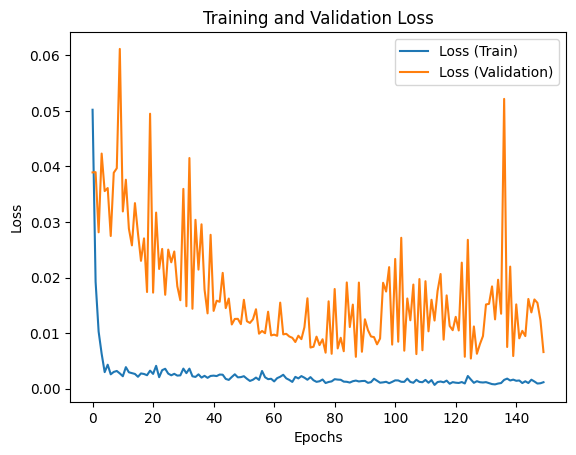

In [80]:
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [81]:
# Desnormalizar las predicciones y los valores reales para interpretarlos mejor
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

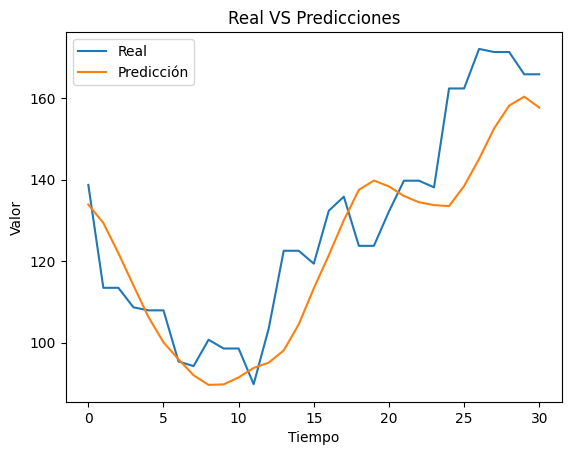

In [82]:
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicción')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Real VS Predicciones')
plt.legend()
plt.show()